## Activation Patching

In [2]:
import torch, transformer_lens, itertools
from functools import partial
from tqdm import tqdm
from measureLM import visualizing, decoding, patching, scoring

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

def plot_heatmap(array, title='', cmap="binary"):
    titlefont, labelsize=12, 10
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=hook_names, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center')
    ax.set_ylabel('layers', fontsize=labelsize)
    plt.show()

In [3]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


In [4]:
def select_logits(logits, token_list=["friendly", "hostile"]): #["positive", "negative"], ["friendly", "hostile"]
    indices = torch.LongTensor([model.tokenizer.encode(f" {token}")[0] for token in token_list])
    logits = torch.index_select(logits, -1, indices)
    logits_v = logits / logits.sum()
    return logits_v[0].item() ## toDo: remove this later!


def get_vector_dist(vec_a, vec_b, norm=True):
    pdist = torch.nn.PairwiseDistance(p=2)
    if norm:
        vec_a = torch.nn.functional.normalize(vec_a, p=2.0, dim=-1)
        vec_b = torch.nn.functional.normalize(vec_b, p=2.0, dim=-1)
    vec_dist = pdist(vec_a, vec_b)
    return vec_dist

## Check change

In [5]:
prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
corrupt_prompt = ["The relationship between Mikel Black and Wesley Smith is"]

prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
corrupt_prompt = ["Harry absolutely hates Ron. The relationship between Harry Potter and Ronald Weasley is"]

#prompt = ["The relationship between Biden and Trump is"]
#corrupt_prompt = ["Biden loves Trump. The relationship between Biden and Trump is"]


logits, activs = model.run_with_cache(prompt)
corrupt_logits, corrupt_activs = model.run_with_cache(corrupt_prompt)

logits_v = select_logits(logits[0,-1])
corrupt_logits_v = select_logits(corrupt_logits[0,-1])

print(logits_v, corrupt_logits_v)

0.5680946707725525 0.48172956705093384


## Find Mechanistic Module

In [6]:
def patch_hook_point(patched_activs, hook: HookPoint, old_activs, hook_layer_name, extract_tok_idx=-1, insert_tok_idx=None):
    #print(f'patching {hook.name} <-- {hook_layer_name}')
    if extract_tok_idx is None or extract_tok_idx == -1:
        extract_tok_idx = (0, -1)
    if insert_tok_idx is None:
        insert_tok_idx = extract_tok_idx
    old_activs_hook = old_activs[hook_layer_name]
    patched_activs[insert_tok_idx] = old_activs_hook[extract_tok_idx]
    return patched_activs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████████| 24/24 [00:08<00:00,  2.98it/s]


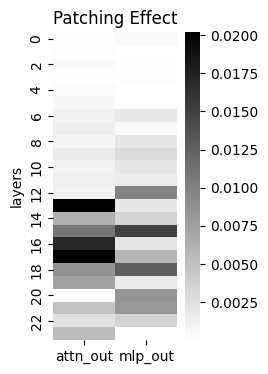

In [7]:
n_layers = model.cfg.n_layers
hook_names = ["attn_out", "mlp_out"]

patching_effect = torch.zeros(n_layers, len(hook_names)) ## times hook_names

for layer in tqdm(range(n_layers)):
    for hook_i, hook_name in enumerate(hook_names): 
        
        hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
        patch_layers_fn = [(hook_layer_name, partial(patch_hook_point, old_activs=corrupt_activs, hook_layer_name=hook_layer_name))]
        corrupt_logits = model.run_with_hooks(prompt,fwd_hooks=patch_layers_fn,reset_hooks_end=True)
        
        logits_v = select_logits(logits[0,-1])
        corrupt_logits_v = select_logits(corrupt_logits[0,-1])        
        patching_effect[layer, hook_i] = abs(logits_v-corrupt_logits_v)
        
plot_heatmap(patching_effect.numpy(), title='Patching Effect', cmap="binary")

In [67]:
def patch_hook_activs(patched_activs, hook: HookPoint, old_activs, hook_layer_name, activ_idx):
    #print(f'patching {hook.name} <-- {hook_layer_name}')
    old_activs_hook = old_activs[hook_layer_name]
    patched_activs[0,-1,activ_idx] = old_activs_hook[0,-1,activ_idx]

hook_name_layer = ["mlp_out", 17]
patching_effect = torch.zeros(1, model.cfg.d_model) ## times hook_names


hook_layer_name = transformer_lens.utils.get_act_name(hook_name_layer[0], hook_name_layer[1])
for activ_i in tqdm(range(0,model.cfg.d_model)):

    patch_layers_fn = [(hook_layer_name, partial(patch_hook_activs, old_activs=corrupt_activs, hook_layer_name=hook_layer_name, activ_idx=activ_i))]
    corrupt_logits = model.run_with_hooks(prompt,fwd_hooks=patch_layers_fn,reset_hooks_end=True)

    logits_v = select_logits(logits[0,-1])
    corrupt_logits_v = select_logits(corrupt_logits[0,-1])        
    patching_effect[0, activ_i] = abs(logits_v-corrupt_logits_v)
        

  0%|                                          | 1/1024 [00:00<02:58,  5.72it/s]

torch.Size([1024])
torch.Size([1024])


  0%|                                          | 3/1024 [00:00<02:48,  6.05it/s]

torch.Size([1024])
torch.Size([1024])


  0%|▏                                         | 5/1024 [00:00<02:47,  6.09it/s]

torch.Size([1024])
torch.Size([1024])


  1%|▎                                         | 7/1024 [00:01<02:45,  6.13it/s]

torch.Size([1024])
torch.Size([1024])


  1%|▎                                         | 9/1024 [00:01<02:44,  6.16it/s]

torch.Size([1024])
torch.Size([1024])


  1%|▍                                        | 11/1024 [00:01<02:45,  6.11it/s]

torch.Size([1024])
torch.Size([1024])


  1%|▌                                        | 13/1024 [00:02<02:45,  6.11it/s]

torch.Size([1024])
torch.Size([1024])


  1%|▌                                        | 15/1024 [00:02<02:44,  6.15it/s]

torch.Size([1024])
torch.Size([1024])


  2%|▋                                        | 17/1024 [00:02<02:43,  6.17it/s]

torch.Size([1024])
torch.Size([1024])


  2%|▊                                        | 19/1024 [00:03<02:42,  6.19it/s]

torch.Size([1024])
torch.Size([1024])


  2%|▊                                        | 19/1024 [00:03<02:52,  5.84it/s]


KeyboardInterrupt: 

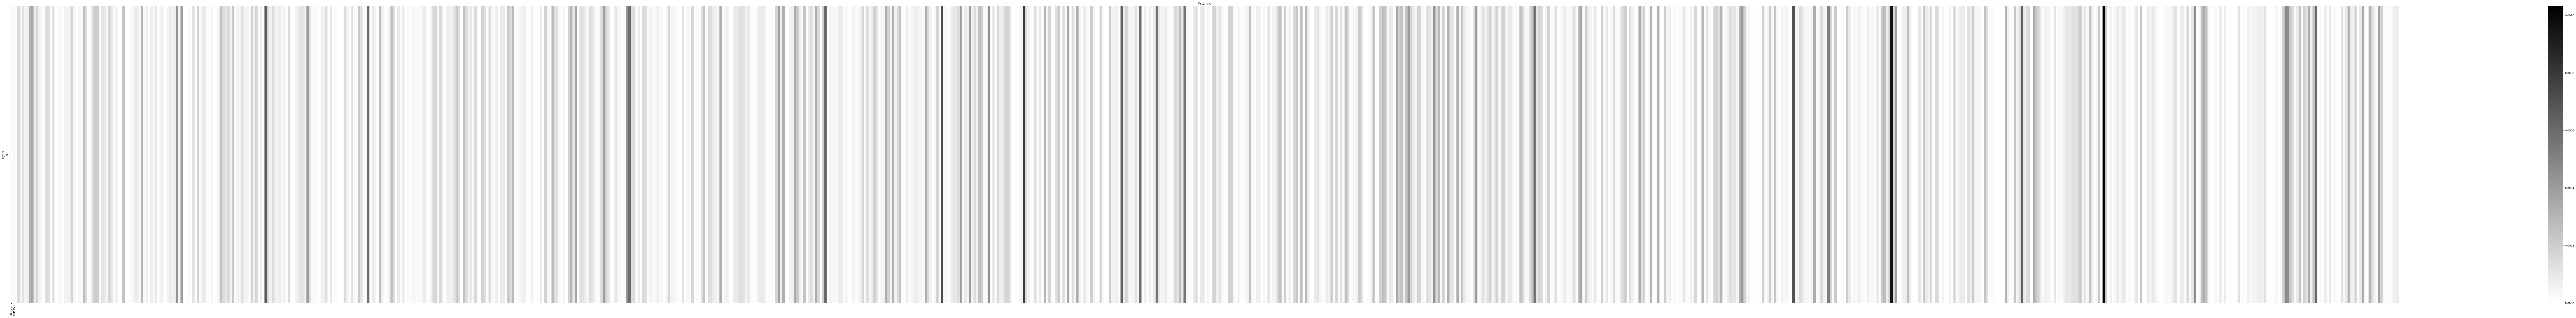

In [66]:
titlefont, labelsize=12, 10
fig, ax = plt.subplots(1, 1, figsize=(200, 20), gridspec_kw={'hspace': 0.4})
ax = sns.heatmap(patching_effect, cmap=mpl.colormaps["binary"], xticklabels=hook_names, square=False)
ax.set_title("Patching", fontsize=titlefont, color="black", loc='center')
ax.set_ylabel('layers', fontsize=labelsize)
plt.show()